In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
import numpy as np

# verify if GPU is available
print(tf.test.is_gpu_available())

# set memory growth to true
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Setting memory growth to True for GPU: ", physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# dont display much info of tensorflow
tf.get_logger().setLevel('ERROR')


2024-01-14 12:41:08.334143: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 12:41:08.415177: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 12:41:08.415219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 12:41:08.418403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 12:41:08.433816: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-01-14 12:41:12.087323: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 12:41:12.155290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 12:41:12.155453: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path) # only laser power and velocity
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

feats = np.load(feats_path)
print("feats shape: ", feats.shape) # feats shape:  (100, 2, 2, 2, 2, 2, 2, 2, 2, 2)


manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
y shape:  (9587, 2)
feats shape:  (9587, 8)


In [3]:
# dimensions of MP are the index 1 and 2 of column in feat

dim_lh = feats[:, 1:3]

max_lh = dim_lh.max(axis=0)

# normalize dim_lh based on max value of each column
dim_lh = dim_lh / max_lh

dim_lh


array([[0.11637931, 0.13836478],
       [0.11206897, 0.1572327 ],
       [0.14224138, 0.13836478],
       ...,
       [0.87068966, 0.47798742],
       [0.87068966, 0.47798742],
       [0.85344828, 0.48427673]])

In [4]:
# concatenate manta and xiris images with label y_encoded as rows
# concatenate the two inputs (manta and xiris) along rows
# expand the dimension of x to 4D
manta = np.expand_dims(manta, axis=3)
xiris = np.expand_dims(xiris, axis=3)
x = np.concatenate((manta, xiris), axis=3)
y = dim_lh
print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (9587, 320, 320, 2)
y shape:  (9587, 2)


In [5]:


# split data into train and test (manta as input and y as output) with shuffle as true
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
 

x_train shape:  (7669, 320, 320, 2)
y_train shape:  (7669, 2)
x_test shape:  (1918, 320, 320, 2)
y_test shape:  (1918, 2)


In [6]:
del manta, xiris, y, dim_lh, x

In [7]:
def build_simpleCNN_model(resolution, n_channels, n_classes):
    """
        Build a simple CNN model with 2 convolutional layers, 2 max pooling layers, 1 fully connected layer and 1 output layer.
        The model is built using the Keras functional API.
        The model is compiled with the Adam optimizer and the categorical cross entropy loss function.
    """
    
    # Define the input shape
    input_shape = Input(shape=(resolution, resolution, n_channels))
    x = Conv2D(4, (3, 3), activation='relu')(input_shape) # 32
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(8, (3, 3), activation='relu')(x) # 64
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)

    # Add a fully connected layer with 128 units and a ReLU activation function
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)
    # Add two output layers each with 1 unit and a linear activation function
    output1 = Dense(n_classes, activation="linear")(x)

    # Define the model with the specified input and outputs
    model = Model(inputs=input_shape, outputs=output1)
    return model

In [8]:
# build model
resolution = X_test.shape[1]
n_channels = X_test.shape[3]
n_classes = y_test.shape[1]

print("resolution: ", resolution)
print("n_channels: ", n_channels)
print("n_classes: ", n_classes)

# build model
model = build_simpleCNN_model(resolution, n_channels, n_classes)

# compile model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# print model summary
model.summary()

battch_size = 32
epochs = 20
validation_split = 0.2

# train model
history = model.fit(X_train, y_train,
                    batch_size=battch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=validation_split)


resolution:  320
n_channels:  2
n_classes:  2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 2)]     0         
                                                                 
 conv2d (Conv2D)             (None, 318, 318, 4)       76        
                                                                 
 max_pooling2d (MaxPooling2  (None, 159, 159, 4)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 157, 8)       296       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 78, 78, 8)         0         
 g2D)                                                            
                                                                 
 flatten (Flatt

2024-01-14 12:41:32.202028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 12:41:32.202264: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 12:41:32.202357: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/20


2024-01-14 12:41:45.411599: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-14 12:41:45.547037: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-14 12:41:46.263822: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-14 12:41:47.440780: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa00e084720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-14 12:41:47.440941: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-14 12:41:47.447063: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705236107.646581 1058871 device_compiler.h:186] 

192/192 [==============================] - 14s 47ms/step - loss: 0.4923 - mse: 0.4923 - mae: 0.5138 - val_loss: 0.2144 - val_mse: 0.2144 - val_mae: 0.4187
Epoch 2/20
192/192 [==============================] - 5s 25ms/step - loss: 0.1674 - mse: 0.1674 - mae: 0.3592 - val_loss: 0.1261 - val_mse: 0.1261 - val_mae: 0.3012
Epoch 3/20
192/192 [==============================] - 5s 25ms/step - loss: 0.0978 - mse: 0.0978 - mae: 0.2541 - val_loss: 0.0755 - val_mse: 0.0755 - val_mae: 0.2170
Epoch 4/20
192/192 [==============================] - 5s 25ms/step - loss: 0.0605 - mse: 0.0605 - mae: 0.1888 - val_loss: 0.0505 - val_mse: 0.0505 - val_mae: 0.1704
Epoch 5/20
192/192 [==============================] - 5s 25ms/step - loss: 0.0428 - mse: 0.0428 - mae: 0.1567 - val_loss: 0.0393 - val_mse: 0.0393 - val_mae: 0.1496
Epoch 6/20
192/192 [==============================] - 5s 28ms/step - loss: 0.0352 - mse: 0.0352 - mae: 0.1419 - val_loss: 0.0350 - val_mse: 0.0350 - val_mae: 0.1401
Epoch 7/20
192/192 [

In [9]:
# evaluate model
score = model.evaluate(X_test, y_test)
print(score)

60/60 [==============================] - 1s 16ms/step - loss: 0.0319 - mse: 0.0319 - mae: 0.1367
[0.031887054443359375, 0.031887054443359375, 0.1367320567369461]


60/60 [==============================] - 1s 14ms/step
r2 score:  -0.00099207567829096


/home/vm/laser/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


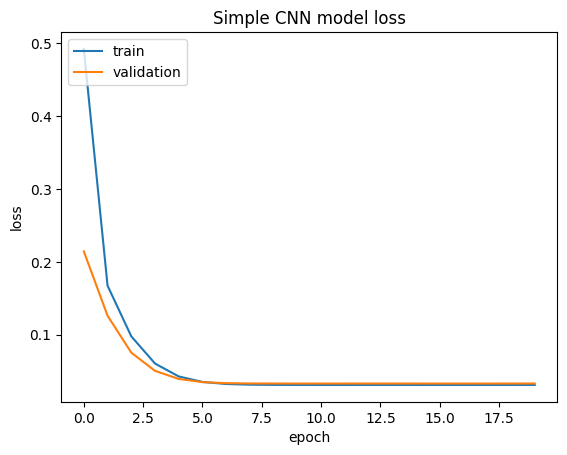

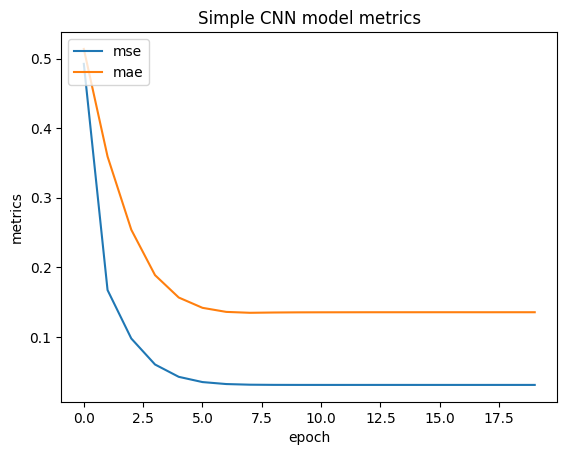

In [10]:
# eval regression model
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score: ", r2)

# save model
model.save("simpleCNN_model.h5")

# plot loss and metrics: mse and mae
import matplotlib.pyplot as plt

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Simple CNN model loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot mse and mae in the same plot
plt.plot(history.history['mse'])
plt.plot(history.history['mae'])
plt.title('Simple CNN model metrics')
plt.ylabel('metrics')

plt.xlabel('epoch')
plt.legend(['mse', 'mae'], loc='upper left')
plt.show()




In [11]:
# make a black image with the same shape as X_test[0]
black_image = np.zeros(X_test[0].shape[0])
print(black_image.shape)

# replace the second channel with the black image 
X_test_new = np.copy(X_test)
X_test_new[:, :, :, 1] = black_image

""" x = X_test_new[10]
# plot first and second channel of x
plt.imshow(x[:, :, 0])
plt.show()
plt.imshow(x[:, :, 1])
plt.show()
 """

(320,)


' x = X_test_new[10]\n# plot first and second channel of x\nplt.imshow(x[:, :, 0])\nplt.show()\nplt.imshow(x[:, :, 1])\nplt.show()\n '

In [12]:
# evL«aluate model with the new X_test_new
score_new = model.evaluate(X_test_new, y_test)
print(score)


60/60 [==============================] - 1s 15ms/step - loss: 0.0318 - mse: 0.0318 - mae: 0.1365
[0.031887054443359375, 0.031887054443359375, 0.1367320567369461]


score:  [0.031887054443359375, 0.031887054443359375, 0.1367320567369461]
score_new:  [0.031797412782907486, 0.031797412782907486, 0.13654863834381104]
60/60 [==============================] - 1s 14ms/step
(1918, 2)


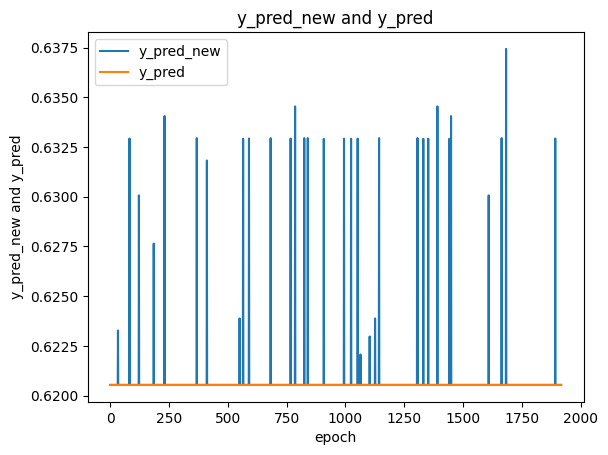

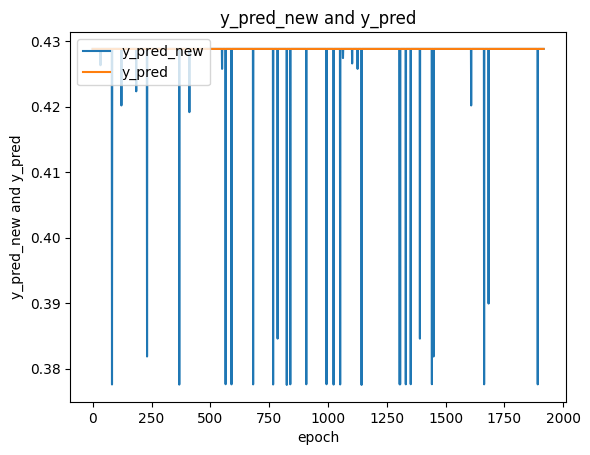

In [13]:
# compare score and score_new
print("score: ", score)
print("score_new: ", score_new)

# predict y_pred_new
y_pred_new = model.predict(X_test_new)
print(y_pred_new.shape)

# plot y_pred_new and y_pred
plt.plot(y_pred_new[:, 0])
plt.plot(y_pred[:, 0])
plt.title('y_pred_new and y_pred')
plt.ylabel('y_pred_new and y_pred')

plt.xlabel('epoch')
plt.legend(['y_pred_new', 'y_pred'], loc='upper left')
plt.show()

# plot y_pred_new and y_pred
plt.plot(y_pred_new[:, 1])
plt.plot(y_pred[:, 1])
plt.title('y_pred_new and y_pred')
plt.ylabel('y_pred_new and y_pred')

plt.xlabel('epoch')
plt.legend(['y_pred_new', 'y_pred'], loc='upper left')
plt.show()
